# Waddington OT

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import os
import seaborn as sns

import wot
from skin_ilc_util import mpl_set_default_style, cm_gray_red, \
    cm_hcl_yellow_red2, day_palette, cm_purple_scatter

/data/Development/Work/PsoriasisILC/pso_ilc_conda_test/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


## Load data

This switch determines if we re-calculate the transport maps

In [4]:
redo_calculations = False
#redo_calculations = True

Load expression data

In [5]:
data_dir = os.path.join('.', 'data')
adata_variable_fname = os.path.join(data_dir, 'sct_variable.h5ad')

In [6]:
adata = sc.read(adata_variable_fname)

In [7]:
init_columns = adata.obs.columns

## Exclude proliferating cells

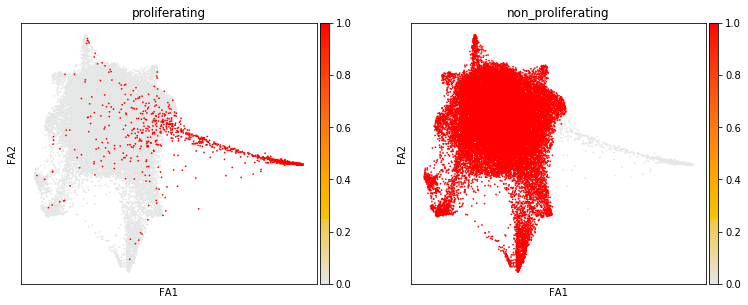

In [8]:
thr = 0.08
ptsize = 12
adata.obs['non_proliferating'] = adata.obs['lda_17'] <= thr
adata.obs['proliferating'] = adata.obs['lda_17'] > thr
(fig, axes) = plt.subplots(1, 2, figsize = (2*6.4, 4.8))
sc.pl.draw_graph(adata, color = ['proliferating'], cmap = cm_gray_red, ax = axes[0], show = False, s = ptsize)
sc.pl.draw_graph(adata, color = ['non_proliferating'], cmap = cm_gray_red, ax = axes[1], s = ptsize)

## Starting cells

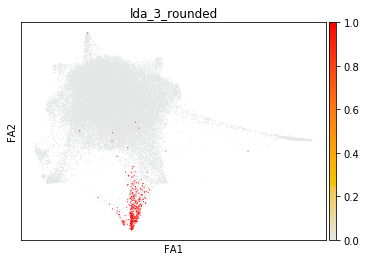

In [9]:
adata.obs['lda_3_rounded'] = (adata.obs['lda_3'] > 0.2) & (adata.obs['day'] == '4')
sc.pl.draw_graph(adata, color = 'lda_3_rounded', cmap = cm_gray_red)

Restrict to non proliferating cells.

In [10]:
adata_focus = adata[adata.obs['non_proliferating'],:]

## Calculating the transport maps

In [11]:
tmap_prefix = os.path.join(data_dir, 'optimal_transport', 'tmap')
os.makedirs(tmap_prefix, exist_ok = True)
adata_focus.X = adata_focus.layers['scale_data']
adata_focus = adata_focus.copy()
adata_focus.obs['day'] = adata_focus.obs['day'].astype(int)

/home/jc/.local/lib/python3.7/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [12]:
ot_model = wot.ot.OTModel(
    matrix = adata_focus,
    epsilon = 0.05,
    lambda1 = 10,
    lambda2 = 50,
    growth_iters = 1,
    local_pca = 10)

In [13]:
if redo_calculations:
    ot_model.compute_all_transport_maps(tmap_out = tmap_prefix)

## Calculating ancestors

Load saved model

In [14]:
tmap_model = wot.tmap.TransportMapModel.from_directory(tmap_prefix)

In [15]:
populations = tmap_model.population_from_ids(adata.obs.index[adata.obs["lda_3_rounded"] == 1].values, at_time = 4)
trajectory_ds = tmap_model.trajectories(populations)

In [16]:
adata_focus.obs["ilc3_precursors"] = trajectory_ds.X.flatten()

/data/Development/Work/PsoriasisILC/pso_ilc_conda_test/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


## Plotting result

In [17]:
adata_var = adata
adata = adata_focus

Text(0.5, 1.0, 'Starting cells, day 4')

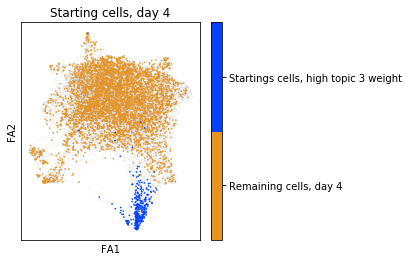

In [18]:
picked_col = '#0042FF'
unpicked_col = '#E69324'
from_list = matplotlib.colors.LinearSegmentedColormap.from_list
cmap = from_list(None, [unpicked_col, picked_col], 2)


fig, ax = plt.subplots(figsize = (4,4))
ax.scatter(*adata.obsm['X_draw_graph_fa'].T, c = '#cccccc', s = 0.01)
sel = adata.obs['day'] == 4
coords = adata.obsm['X_draw_graph_fa'][sel, :]
probs = adata.obs['ilc3_precursors'][sel]
ind = np.argsort(probs)
c = probs[ind]
data = ax.scatter(*coords[ind,:].T, c = c, s = 0.4, cmap = cmap)
max_val = adata.obs['ilc3_precursors'][sel].max()
cbar = plt.colorbar(data, ax = ax, 
                   ticks = [max_val/4, max_val*3/4])
cbar.ax.set_yticklabels(['Remaining cells, day 4', 'Startings cells, high topic 3 weight'])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('FA1')
ax.set_ylabel('FA2')
ax.set_title('Starting cells, day {}'.format(4))

Plot probabilities

Text(0.5, 0.98, 'OT precursor probabilities')

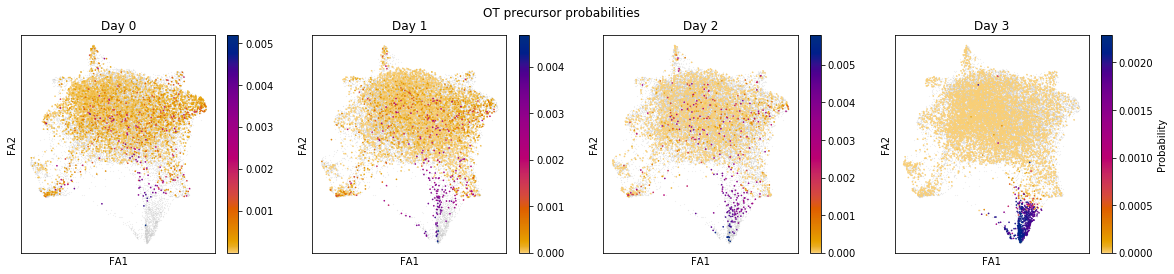

In [19]:
fig, axes = plt.subplots(ncols = 4, figsize = (4*5, 4))
for (day, ax) in zip([0, 1, 2, 3], axes):
    ax.scatter(*adata.obsm['X_draw_graph_fa'].T, c = '#cccccc', s = 0.01)
    sel = adata.obs['day'] == day
    coords = adata.obsm['X_draw_graph_fa'][sel, :]
    probs = adata.obs['ilc3_precursors'][sel]
    ind = np.argsort(probs)
    c = probs[ind]
    data = ax.scatter(*coords[ind,:].T, c = c, s = 0.4, cmap = cm_hcl_yellow_red2)
    cbar = plt.colorbar(data, ax = ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('FA1')
    ax.set_ylabel('FA2')
    ax.set_title('Day {}'.format(day))
        
cbar.set_label('Probability')
fig.suptitle('OT precursor probabilities')

## Validation

In [20]:
save_dir = os.path.join(data_dir, 'optimal_transport')

Perform the validation calculation.

In [21]:
if redo_calculations:
    np.random.seed(0)
    summary = wot.ot.compute_validation_summary(ot_model, compute_full_distances = True)
    summary.to_csv(os.path.join(save_dir, 'validation_results.csv'))
else:
    summary = pd.read_csv(os.path.join(save_dir, 'validation_results.csv'), index_col = 0)

We have no batches, so only use the results without covariates

In [22]:
summary = summary[summary['cv0'].isna()]

Plot validation results

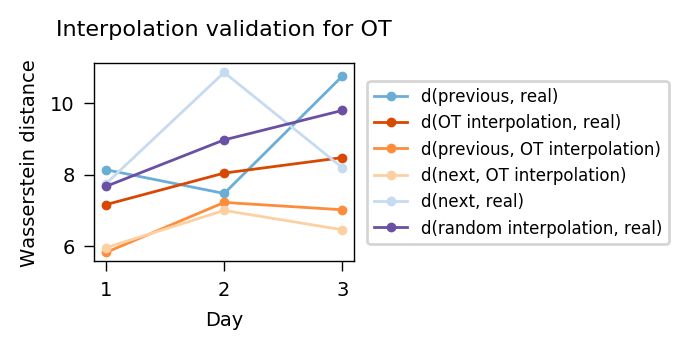

In [23]:
# Legends for the plot
ot_colors = sns.palettes.color_palette('Oranges', 3)
random_interp_color = sns.palettes.color_palette('Purples', 3)[-1]
non_ot_colors = sns.palettes.color_palette('Blues', 3)
ot_validation_legend = {
    'I': [ot_colors[-1], "d(OT interpolation, real)"],
    'F': [non_ot_colors[-2], "d(previous, real)"],
    'L': [non_ot_colors[-3], "d(next, real)"],
    'R': [random_interp_color, "d(random interpolation, real)"],
    'I1': [ot_colors[-2], "d(previous, OT interpolation)"],
    'I2': [ot_colors[-3], "d(next, OT interpolation)"]
}

# Calculate spacing for the plot
left_width, panel_width, wspace_width, right_width = (0.56, 1.2999999999999998, 0.38999999999999996, 0.07000000000000006)
total_width = panel_width + 2*wspace_width
left = wspace_width/total_width
right = 1 - wspace_width/total_width

# Plot results
fig, ax = plt.subplots(figsize = (total_width, 1.8), dpi = 200)
fontsize = 7
spine_width = 0.5

for (i, (p, d)) in enumerate(summary.groupby('name')):
    if p not in ot_validation_legend:
        continue
    t = d['interval_mid']
    v = d['distance']
    ax.plot(t, v, c = ot_validation_legend[p][0], label = ot_validation_legend[p][1], marker = '.', markersize = 5,
           linewidth = 1)
    ax.set_xlabel('Day', fontsize = fontsize)
    ax.set_ylabel("Wasserstein distance", fontsize = fontsize)
    ax.set_xticks([1, 2, 3])
    ax.tick_params(axis = 'both', labelsize = fontsize)
    
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    fig.subplots_adjust(top = 0.75, bottom = 0.2, left = left, right = right)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad = 0, fontsize = fontsize - 1)
    ax.set_title('Interpolation validation for OT', fontsize = fontsize + 1, pad = 10)
    plt.setp(ax.spines.values(), linewidth = spine_width)
    plt.setp(ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines(), markeredgewidth = spine_width)

## Save data

In [24]:
adata_full_fname = os.path.join(data_dir, 'sct.h5ad')
adata_full = sc.read(adata_full_fname)

In [25]:
adata_var.obs['ilc3_precursors_ot'] = np.nan
adata_var.obs['ilc3_precursors_ot'] = adata.obs['ilc3_precursors'].copy()
adata_var.obs = adata_var.obs[list(init_columns) + ['ilc3_precursors_ot']]
adata_full.obs['ilc3_precursors_ot'] = adata_var.obs['ilc3_precursors_ot']

In [26]:
adata_var.write(adata_variable_fname)
adata_full.write(adata_full_fname)